<a href="https://colab.research.google.com/github/AisIzmailova/AisIzmailova_Practice_Notebooks/blob/master/Project2_Skimlit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#SkimLiterature

The purpose of this notebook is to buils an NLP model to make reading medical abstracts easier.

The paper we are replicating is available [here](https://arxiv.org/abs/1710.06071).

The model architecture is available [here](https://arxiv.org/abs/1612.05251).

##Get the data

Since we are replicating the paper, let's download the dataset they used.

In [1]:
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import zipfile
import os
import pathlib
import numpy as np
import random
import datetime

In [2]:
from Helper_functions import unzip_file

In [3]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct.git

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 39, done.
remote: Counting objects: 100% (14/14), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 39 (delta 8), reused 5 (delta 5), pack-reused 25
Receiving objects: 100% (39/39), 177.08 MiB | 36.33 MiB/s, done.
Resolving deltas: 100% (15/15), done.


In [4]:
!ls pubmed-rct

PubMed_200k_RCT				       PubMed_20k_RCT_numbers_replaced_with_at_sign
PubMed_200k_RCT_numbers_replaced_with_at_sign  README.md
PubMed_20k_RCT


In [5]:
!ls pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/

dev.txt  test.txt  train.txt


In [6]:
data_dir = "pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/"

In [7]:
filenames=[data_dir + "/" + filename for filename in os.listdir(data_dir)]
filenames

['pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign//test.txt',
 'pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign//dev.txt',
 'pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign//train.txt']

##Preprocess the data

In [8]:
#Create function to read the lines of the document
def get_lines(filename):
  """
  Read filename and returns the lines of text as a list.
  """
  with open(filename, "r") as f:
    return f.readlines()

In [9]:
train_lines = get_lines(data_dir+"train.txt")
train_lines[:20]

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

In [10]:
len(train_lines)

210040

In [11]:
def preprocess_text_with_line_numbers(filename):
  """
  Returns a list of dictionaries of abstract line data.
  Takes in filename, reads its contents and sorts through  each line,
  extracting things like the target label, the text of the sentence,
  how many sentences are in the current abstract and what sentence
  number the target line is.
  """
  input_lines = get_lines(filename)

  absract_lines = "" #create an empty abstract
  abstract_samples = [] #create an empty dictionary

  #Loop through each line in the target file
  for line in input_lines:
    if line.startswith("###"): #check to see if there is a new ID line
      abstract_id=line
      abstract_lines = "" #reset the abstract string if the line is ID
    elif line.isspace(): #check to see if a line is new empty line
      abstract_line_split = abstract_lines.splitlines() #split abstract into separate lines

      #Iterate through each line in a single abstract and count them
      for abstract_line_number, abstract_line in enumerate(abstract_line_split):
        line_data = {} #create an empty dictionary for each line
        target_text_split = abstract_line.split("\t") #split at tab
        line_data["target"] = target_text_split[0] #get target label
        line_data["text"] = target_text_split[1].lower() #get target text in lower case
        line_data["line_number"] = abstract_line_number
        line_data["total_lines"] = len(abstract_line_split)-1 #hoe many lines in abstract
        abstract_samples.append(line_data)

    else: #if the above condition is not fulfilled, the line contains a labelled sentence
        abstract_lines+=line

  return abstract_samples

In [12]:
#Get data from file and preprocess it
%%time
train_samples = preprocess_text_with_line_numbers(data_dir+"train.txt")
test_samples = preprocess_text_with_line_numbers(data_dir+"test.txt")
val_samples = preprocess_text_with_line_numbers(data_dir+"dev.txt")

CPU times: user 379 ms, sys: 81 ms, total: 460 ms
Wall time: 462 ms


In [13]:
len(train_samples), len(test_samples), len(val_samples)

(180040, 30135, 30212)

In [14]:
train_samples[:10]

[{'target': 'OBJECTIVE',
  'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'line_number': 0,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
  'line_number': 1,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
  'line_number': 2,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
  'line_number': 3,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'secondary outcome measures included the western ontari

In [15]:
#Turn data dictionary into DataFrame
train_df = pd.DataFrame(train_samples)
test_df = pd.DataFrame(test_samples)
val_df = pd.DataFrame(val_samples)
train_df.head()

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11


In [16]:
train_df.target.value_counts()

METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: target, dtype: int64

<Axes: ylabel='Frequency'>

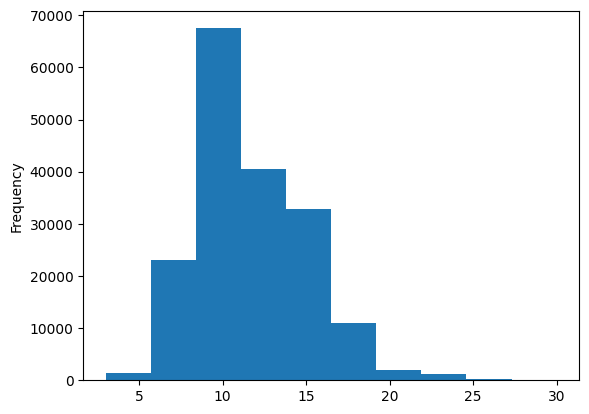

In [17]:
#Let's check the length of different lines
train_df.total_lines.plot.hist()

##Get lists of sentences

In [18]:
#Convert abstract text lines into lists
train_sentences = train_df["text"].tolist()
test_sentences = test_df["text"].tolist()
val_sentences = val_df["text"].tolist()

In [19]:
len(train_sentences), train_sentences[:5]

(180040,
 ['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
  'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
  'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
  'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .'])

##Making labels numeric

In [20]:
from sklearn.preprocessing import OneHotEncoder
one_hot_encoder = OneHotEncoder(sparse_output=False)
train_labels_one_hot = one_hot_encoder.fit_transform(train_df["target"].to_numpy().reshape(-1,1))
train_labels_one_hot

array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

In [21]:
val_labels_one_hot = one_hot_encoder.transform(val_df["target"].to_numpy().reshape(-1,1))
test_labels_one_hot = one_hot_encoder.transform(test_df["target"].to_numpy().reshape(-1,1))

##Label encode labels

In [22]:
#Extract lables and encode them into integers
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
train_labels = label_encoder.fit_transform(train_df["target"].to_numpy())
val_labels = label_encoder.transform(val_df["target"].to_numpy())
test_labels = label_encoder.transform(test_df["target"].to_numpy())

In [23]:
train_labels

array([3, 2, 2, ..., 4, 1, 1])

In [24]:
num_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_
num_classes, class_names

(5,
 array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object))

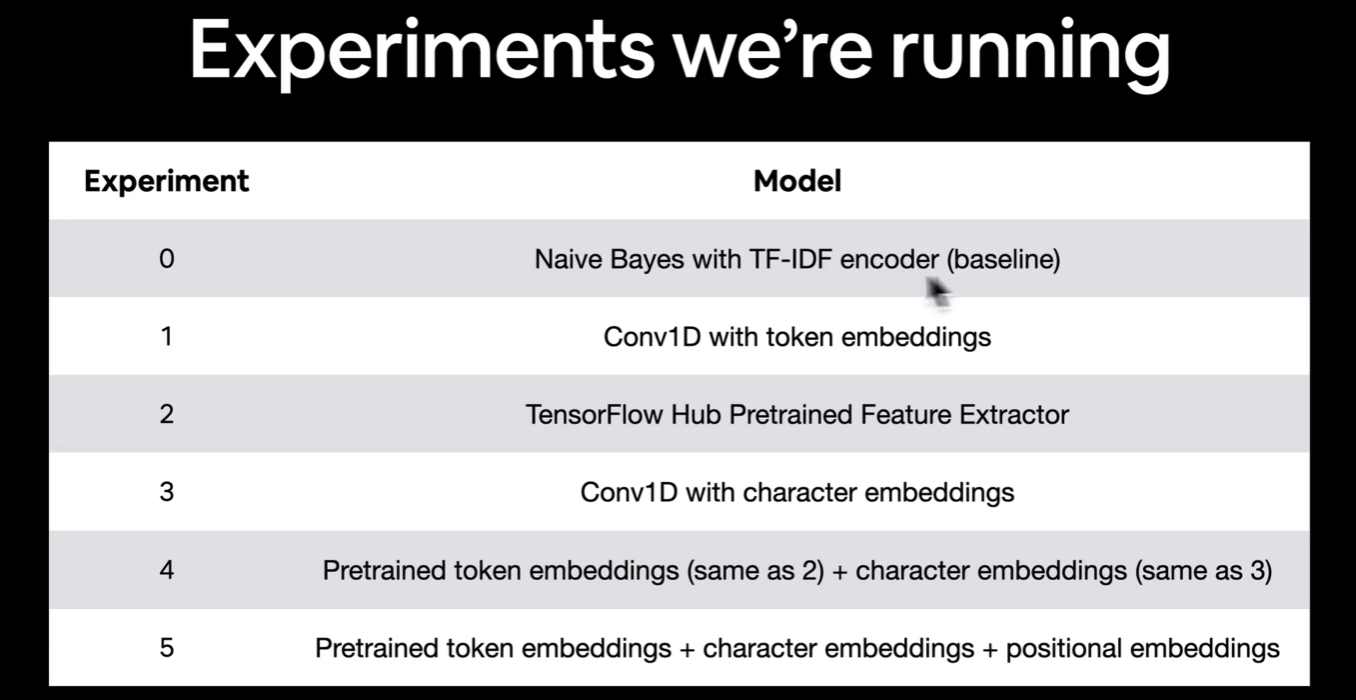

#Build baseline model

In [25]:
#Build TextVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

#Create tokenization and modelling pipeline
model_0 = Pipeline([("tfidf", TfidfVectorizer()), #convert words to numbers using tfidf
                    ("clf", MultinomialNB()) #model the text
                    ])
#Fit the pipeline to training data
model_0.fit(train_sentences, train_labels)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [26]:
#Evaluate the baseline model
baseline_score = model_0.score(val_sentences, val_labels)
print(f"Baseline model accuracy: {baseline_score*100:.2f}")

Baseline model accuracy: 72.18


In [27]:
baseline_preds=model_0.predict(val_sentences)
baseline_preds[:10]

array([4, 1, 3, 2, 2, 2, 2, 2, 4, 4])

In [28]:
baseline_preds.shape

(30212,)

In [29]:
from Helper_functions import calculate_results

In [30]:
baseline_results = calculate_results(val_labels,baseline_preds)
baseline_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

##Tokenize and Embed the text data

In [31]:
#Find the average number of tokens
round(sum([len(i.split()) for i in train_sentences])/len(train_sentences))

26

(array([4.2075e+04, 8.3771e+04, 3.6877e+04, 1.0945e+04, 3.9310e+03,
        1.4450e+03, 5.6000e+02, 2.2600e+02, 1.0100e+02, 4.5000e+01,
        2.0000e+01, 1.2000e+01, 9.0000e+00, 1.0000e+01, 6.0000e+00,
        2.0000e+00, 3.0000e+00, 0.0000e+00, 1.0000e+00, 1.0000e+00]),
 array([  1.  ,  15.75,  30.5 ,  45.25,  60.  ,  74.75,  89.5 , 104.25,
        119.  , 133.75, 148.5 , 163.25, 178.  , 192.75, 207.5 , 222.25,
        237.  , 251.75, 266.5 , 281.25, 296.  ]),
 <BarContainer object of 20 artists>)

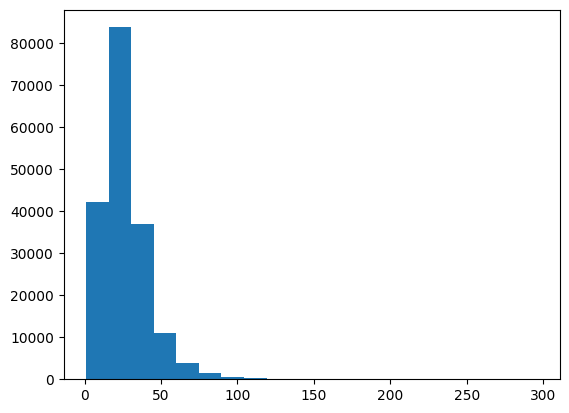

In [32]:
#Find the average number of tokens
sentence_len = [len(i.split()) for i in train_sentences]
plt.hist(sentence_len,bins=20)

In [33]:
#Check 95th percentile
output_seq_len = np.percentile(sentence_len, 95)
output_seq_len

55.0

In [34]:
#Create a vectorization layer
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
#Setup text vectorization variables
max_vocal_length=68000
max_length=55
text_vectorizer = TextVectorization(max_tokens=max_vocal_length, #how many words in the vocabulary
                                    output_sequence_length=max_length)

In [35]:
#Fit the text vectorizer to the training text
text_vectorizer.adapt(train_sentences)

In [36]:
#Choose a random sample from train dataset
random_text = random.choice(train_sentences)
print(f"Original text: {random_text}\n Vectorized version: ")
text_vectorizer([random_text])

Original text: of the @ patients included , @ ( @ % ) completed the study ( ig , @ ; cg , @ ) .
 Vectorized version: 


<tf.Tensor: shape=(1, 55), dtype=int64, numpy=
array([[   4,    2,   12,  121,  253,    2,   17, 3081, 1512,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0]])>

In [37]:
#Get the unique words in the vocabulary
words_in_vocab = text_vectorizer.get_vocabulary()
top_5_words=words_in_vocab[:5]
bottom_5_words=words_in_vocab[-5:]
print(f"Number of words in vocabulary: {len(words_in_vocab)}")
print(f"5 most common words: {top_5_words}")
print(f"5 least common words: {bottom_5_words}")

Number of words in vocabulary: 64841
5 most common words: ['', '[UNK]', 'the', 'and', 'of']
5 least common words: ['aainduced', 'aaigroup', 'aachener', 'aachen', 'aaacp']


In [38]:
text_vectorizer.get_config()

{'name': 'text_vectorization',
 'trainable': True,
 'dtype': 'string',
 'batch_input_shape': (None,),
 'max_tokens': 68000,
 'standardize': 'lower_and_strip_punctuation',
 'split': 'whitespace',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 55,
 'pad_to_max_tokens': False,
 'sparse': False,
 'ragged': False,
 'vocabulary': None,
 'idf_weights': None,
 'encoding': 'utf-8',
 'vocabulary_size': 64841}

In [39]:
#Create embedding layer
from tensorflow.keras import layers
from tensorflow.keras.layers import Embedding
embedding = layers.Embedding(input_dim=max_vocal_length,
                      output_dim=128,
                      mask_zero=True,
                      name="token_embedding")

In [40]:
random_text = random.choice(train_sentences)
print(f"Original text: {random_text}\n Embedded version: ")
sample_embed = embedding(text_vectorizer([random_text]))
print(sample_embed)

Original text: plant stanol esters partly block cholesterol absorption in the digestive tract and thereby reduce total cholesterol and low-density lipoprotein ( ldl ) cholesterol serum levels .
 Embedded version: 
tf.Tensor(
[[[-0.04390475  0.04102006  0.02463439 ... -0.00980096  0.03731551
    0.04244757]
  [-0.01034264  0.02502077 -0.03137121 ... -0.0211732   0.00021098
    0.01350338]
  [-0.02216665 -0.03733282  0.03483972 ... -0.03242431  0.02271508
   -0.04597062]
  ...
  [-0.04867617 -0.00199025 -0.02635033 ... -0.04945729  0.01625718
    0.01508209]
  [-0.04867617 -0.00199025 -0.02635033 ... -0.04945729  0.01625718
    0.01508209]
  [-0.04867617 -0.00199025 -0.02635033 ... -0.04945729  0.01625718
    0.01508209]]], shape=(1, 55, 128), dtype=float32)


##Create dataset using tf.data API

Read:
* https://www.tensorflow.org/guide/data_performance
* https://www.tensorflow.org/guide/data


In [41]:
train_ds = tf.data.Dataset.from_tensor_slices((tf.squeeze(train_sentences), tf.squeeze(train_labels_one_hot)))
test_ds = tf.data.Dataset.from_tensor_slices((tf.squeeze(test_sentences), tf.squeeze(test_labels_one_hot)))
val_ds = tf.data.Dataset.from_tensor_slices((tf.squeeze(val_sentences), tf.squeeze(val_labels_one_hot)))
train_ds

<_TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(5,), dtype=tf.float64, name=None))>

In [42]:
#Take Tensorslices datasets and turn them into prefetched datasets with batches
train_ds = train_ds.batch(32).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.batch(32).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.batch(32).prefetch(buffer_size=tf.data.AUTOTUNE)
train_ds

<_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

#Build 1D Convolutional Neural Network model

In [43]:
#Create the model
inputs=layers.Input(shape=(1,), dtype="string")
print(inputs.shape)
x=text_vectorizer(inputs)
print(x.shape)
x=embedding(x)
print(x.shape)
x=layers.Conv1D(filters=64, kernel_size=5, strides=1, padding="same", activation="relu")(x)
print(x.shape)
x=layers.GlobalAveragePooling1D()(x)
print(x.shape)
outputs=layers.Dense(num_classes, activation="softmax")(x)
print(outputs.shape)
model_1=tf.keras.Model(inputs, outputs, name="model_1")

(None, 1)
(None, 55)
(None, 55, 128)
(None, 55, 64)
(None, 64)
(None, 5)


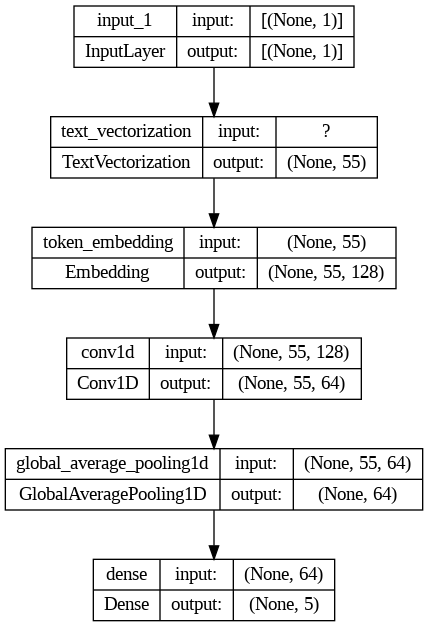

In [151]:
from tensorflow.keras.utils import plot_model
plot_model(model_1, show_shapes=True)

In [44]:
#Compile the model
model_1.compile(
    loss=tf.keras.losses.CategoricalCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(),
    metrics=["accuracy"]
)

In [45]:
from Helper_functions import create_tensorboard_callback

In [46]:
#Fit the model
history_1 = model_1.fit(train_ds,
                        steps_per_epoch=int(0.1*len(train_ds)),
                        epochs=3,
                        validation_data=val_ds,
                        validation_steps=int(0.1*len(val_ds)),
                        callbacks=[create_tensorboard_callback("experiment_log","model_1")])

Saving TensorBoard log files to: experiment_log/model_1/20240105-064749
Epoch 1/3
562/562 [==============================] - 21s 32ms/step - loss: 0.9138 - accuracy: 0.6408 - val_loss: 0.6828 - val_accuracy: 0.7387
Epoch 2/3
562/562 [==============================] - 5s 9ms/step - loss: 0.6584 - accuracy: 0.7563 - val_loss: 0.6332 - val_accuracy: 0.7729
Epoch 3/3
562/562 [==============================] - 6s 10ms/step - loss: 0.6210 - accuracy: 0.7748 - val_loss: 0.5987 - val_accuracy: 0.7839


In [47]:
model_1_preds = model_1.predict(val_ds)
model_1_preds[:10]

945/945 [==============================] - 3s 3ms/step


array([[4.2640871e-01, 2.1084934e-01, 8.7765127e-02, 2.4290486e-01,
        3.2071959e-02],
       [4.2558393e-01, 2.8349310e-01, 1.0393696e-02, 2.7443692e-01,
        6.0923281e-03],
       [1.2669659e-01, 8.7074134e-03, 1.3857026e-03, 8.6318481e-01,
        2.5432413e-05],
       [1.6734486e-05, 2.1011710e-04, 9.7918576e-01, 1.0968989e-05,
        2.0576417e-02],
       [1.3388743e-03, 2.8567366e-02, 2.9840508e-01, 8.1599341e-04,
        6.7087269e-01],
       [2.0044979e-02, 3.1468440e-02, 5.7258767e-01, 8.6190142e-03,
        3.6727983e-01],
       [4.7181975e-04, 4.3320819e-03, 2.3840654e-01, 1.9098535e-04,
        7.5659859e-01],
       [3.3055346e-02, 3.1816922e-02, 6.7424518e-01, 1.6757851e-02,
        2.4412474e-01],
       [2.7407170e-13, 3.3824257e-08, 1.5494876e-07, 4.4236682e-14,
        9.9999976e-01],
       [1.0682083e-02, 6.4873582e-01, 4.2726591e-02, 2.1898085e-02,
        2.7595741e-01]], dtype=float32)

In [48]:
model_1.evaluate(val_ds)

945/945 [==============================] - 3s 3ms/step - loss: 0.6018 - accuracy: 0.7842


[0.6017628312110901, 0.784224808216095]

In [49]:
model_1_pred = tf.argmax(model_1_preds, axis=1)

In [50]:
model_1_result = calculate_results(val_labels, model_1_pred)
model_1_result

{'accuracy': 78.42248113332451,
 'precision': 0.7812092406552386,
 'recall': 0.7842248113332451,
 'f1': 0.7819445726055091}

In [51]:
model_1_pred_classes = class_names[tf.argmax(model_1_preds, axis=1)]

In [52]:
model_1_pred_classes[:10]

array(['BACKGROUND', 'BACKGROUND', 'OBJECTIVE', 'METHODS', 'RESULTS',
       'METHODS', 'RESULTS', 'METHODS', 'RESULTS', 'CONCLUSIONS'],
      dtype=object)

#Building feature extraction pretrained model

In [53]:
import tensorflow_hub as hub
model_url = "https://www.kaggle.com/models/google/universal-sentence-encoder/frameworks/TensorFlow2/variations/universal-sentence-encoder/versions/2"
use_embed = hub.load(model_url)

In [54]:
#Test out pretrained embedding
random_train_sentence = random.choice(train_sentences)
print(f"Random sentence: {random_train_sentence}")
use_embedded_sentence = use_embed([random_train_sentence])
print(f"Sentence after embedding: {use_embedded_sentence[0][:20]}")
print(f"Length of the sentence: {len(use_embedded_sentence[0])}")

Random sentence: anti-ct iga results were similar .
Sentence after embedding: [ 0.00158707  0.02702519 -0.03365441  0.0387981   0.02121119  0.04596035
  0.02702163 -0.07054179 -0.06457593 -0.00234462  0.01434826 -0.000816
  0.04548253 -0.00208787 -0.08018789  0.0520009   0.01302753 -0.0502684
  0.07808491  0.01091749]
Length of the sentence: 512


In [55]:
#Create the model
embed_layer_encoder = hub.KerasLayer(model_url,
                                     input_shape=[], #pretrained model characteristics mention the input shape to be []
                                     dtype=tf.string,
                                     name="use_embed")

model_2 = tf.keras.Sequential([
    embed_layer_encoder,
    layers.Dense(64, activation="relu"),
    layers.Dense(num_classes, activation="softmax")
])

model_2.compile(
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=['accuracy'],
    optimizer=tf.keras.optimizers.Adam()
)
model_2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 use_embed (KerasLayer)      (None, 512)               256797824 
                                                                 
 dense_1 (Dense)             (None, 64)                32832     
                                                                 
 dense_2 (Dense)             (None, 5)                 325       
                                                                 
Total params: 256830981 (979.73 MB)
Trainable params: 33157 (129.52 KB)
Non-trainable params: 256797824 (979.61 MB)
_________________________________________________________________


In [56]:
#Fit the model
history = model_2.fit(train_ds,
            steps_per_epoch=int(0.1*len(train_ds)),
            epochs=3,
            validation_data=val_ds,
            validation_steps=int(0.1*len(val_ds)),
            callbacks = [create_tensorboard_callback("experiment_log","model_2")])

Saving TensorBoard log files to: experiment_log/model_2/20240105-064907
Epoch 1/3
562/562 [==============================] - 13s 18ms/step - loss: 0.9445 - accuracy: 0.6416 - val_loss: 0.8065 - val_accuracy: 0.6802
Epoch 2/3
562/562 [==============================] - 8s 14ms/step - loss: 0.7814 - accuracy: 0.6955 - val_loss: 0.7699 - val_accuracy: 0.7001
Epoch 3/3
562/562 [==============================] - 7s 12ms/step - loss: 0.7697 - accuracy: 0.7042 - val_loss: 0.7579 - val_accuracy: 0.7081


In [57]:
#Evaluate the model
model_2.evaluate(val_ds)

945/945 [==============================] - 9s 10ms/step - loss: 0.7581 - accuracy: 0.7074


[0.7580713033676147, 0.7074341177940369]

In [58]:
#Make predictions
model_2_pred_probs = model_2.predict(val_ds)

945/945 [==============================] - 10s 10ms/step


In [59]:
model_1_preds = tf.argmax(model_2_pred_probs, axis=1)

In [60]:
model_2_results = calculate_results(val_labels, model_1_preds)
model_2_results

{'accuracy': 70.74341321329273,
 'precision': 0.7066501885401197,
 'recall': 0.7074341321329273,
 'f1': 0.7037912850578004}

#Build character embedding model




In [61]:
#Make function to split sentences into characters
def split_chars(text):
  return " ".join(list(text))
#Text splitting non-character-level sequence into characters
split_chars(random_train_sentence)

'a n t i - c t   i g a   r e s u l t s   w e r e   s i m i l a r   .'

In [62]:
train_chars = [split_chars(sentence) for sentence in train_sentences]
test_chars = [split_chars(sentence) for sentence in test_sentences]
val_chars = [split_chars(sentence) for sentence in val_sentences]
train_chars[:5]

['t o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   o a   )   .',
 'a   t o t a l   o f   @   p a t i e n t s   w i t h   p r i m a r y   k n e e   o a   w e r e   r a n d o m i z e d   @ : @   ;   @   r e c e i v e d   @   m g / d a y   o f   p r e d n i s o l o n e   a n d   @   r e c e i v e d   p l a c e b o   f o r   @   w e e k s   .',
 'o u t c o m e   m e a s u r e s   i n c l u d e d   p a i n   r e d u c t i o n   a n d   i m p r o v e m e n t   i n   f u n c t i o n   s c o r e s   a 

In [63]:
#Find the average character length of a sentence
char_len = [len(sentence) for sentence in train_sentences]
mean_char_len = np.mean(char_len)
mean_char_len

149.3662574983337

(array([1.41175e+05, 3.71110e+04, 1.60000e+03, 1.27000e+02, 2.10000e+01,
        5.00000e+00, 1.00000e+00]),
 array([1.00000000e+00, 1.98857143e+02, 3.96714286e+02, 5.94571429e+02,
        7.92428571e+02, 9.90285714e+02, 1.18814286e+03, 1.38600000e+03]),
 <BarContainer object of 7 artists>)

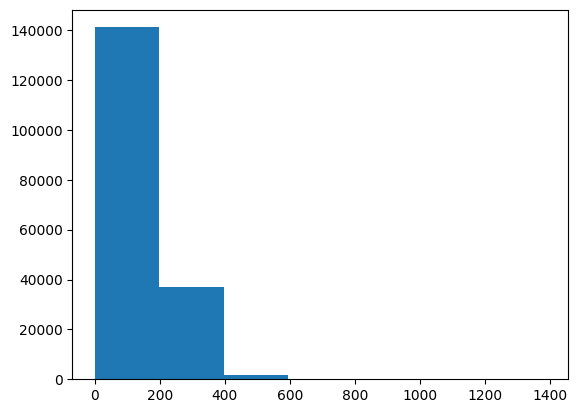

In [64]:
#Check the distribution
plt.hist(char_len, bins=7)

In [65]:
#Check 95th percentile
output_seq_char_len = np.percentile(char_len, 95)
output_seq_char_len

290.0

In [66]:
#Get all keyboard characters
import string
alphabet = string.ascii_lowercase + string.digits + string.punctuation
alphabet

'abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [67]:
#Set up text vectorization layer
num_char_tokens = len(alphabet)+2
char_vectorizer = TextVectorization(max_tokens=num_char_tokens,
                                 output_sequence_length=int(output_seq_char_len),
                                 #standardize=None, #Set standardize to None if you want to keep punctuation
                                 name="char_vectorizer")
char_vectorizer.adapt(train_chars)

In [68]:
#Check character vocab stats
char_vocab = char_vectorizer.get_vocabulary()
print(f"Number of different characters in char vocab: {len(char_vocab)}")
print(f"Top 5 most common characters: {char_vocab[:5]}")
print(f"Top 5 least common characters: {char_vocab[-5:]}")

Number of different characters in char vocab: 28
Top 5 most common characters: ['', '[UNK]', 'e', 't', 'i']
Top 5 least common characters: ['k', 'x', 'z', 'q', 'j']


In [69]:
random_train_chars = random.choice(train_chars)
print(f"Charified text: {random_train_chars}")
print(f"Length of random_train_chars: {len(random_train_chars)}")
vectorized_chars = char_vectorizer([random_train_chars])
print(f"Vectorized chars: {vectorized_chars}")
print(f"Length of vectorized chars: {len(vectorized_chars[0])}")

Charified text: t h e   t e c h n i c a l   s k i l l   a s s e s s m e n t   i n s t r u m e n t   (   t s a i   )   h a s   b e e n   c o n t e n t   v a l i d a t e d   a n d   t e s t e d   f o r   i n t r a r a t e r   r e l i a b i l i t y   .
Length of random_train_chars: 233
Vectorized chars: [[ 3 13  2  3  2 11 13  6  4 11  5 12  9 23  4 12 12  5  9  9  2  9  9 15
   2  6  3  4  6  9  3  8 16 15  2  6  3  3  9  5  4 13  5  9 22  2  2  6
  11  7  6  3  2  6  3 21  5 12  4 10  5  3  2 10  5  6 10  3  2  9  3  2
  10 17  7  8  4  6  3  8  5  8  5  3  2  8  8  2 12  4  5 22  4 12  4  3
  19  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0 

In [70]:
#Create character-level embedding layer
from tensorflow.keras import layers
from tensorflow.keras.layers import Embedding
char_embedding = layers.Embedding(input_dim=len(char_vocab),
                      output_dim=25, #This is the size of char embedding in the paper
                      mask_zero=True,
                      name="char_embedding")

In [71]:
print(f"Original text: {random_train_chars}\n Embedded version: ")
char_embed = char_embedding(char_vectorizer([random_train_chars]))
print(char_embed)
print(f"Char embedding shape: {char_embed.shape}")

Original text: t h e   t e c h n i c a l   s k i l l   a s s e s s m e n t   i n s t r u m e n t   (   t s a i   )   h a s   b e e n   c o n t e n t   v a l i d a t e d   a n d   t e s t e d   f o r   i n t r a r a t e r   r e l i a b i l i t y   .
 Embedded version: 
tf.Tensor(
[[[ 0.00247805 -0.04588345 -0.01554972 ...  0.04640404  0.04194334
    0.01547709]
  [-0.01264961 -0.01688285  0.01799921 ...  0.00920905 -0.02457525
   -0.00313629]
  [ 0.04226318 -0.04934261 -0.04934163 ...  0.0418259   0.01806403
    0.03602346]
  ...
  [ 0.04865625  0.00987458  0.02663186 ... -0.01337276  0.00981413
   -0.00491335]
  [ 0.04865625  0.00987458  0.02663186 ... -0.01337276  0.00981413
   -0.00491335]
  [ 0.04865625  0.00987458  0.02663186 ... -0.01337276  0.00981413
   -0.00491335]]], shape=(1, 290, 25), dtype=float32)
Char embedding shape: (1, 290, 25)


In [72]:
#Optimize dataset for character-level data
train_char_ds = tf.data.Dataset.from_tensor_slices((train_chars, train_labels_one_hot)).batch(32).prefetch(buffer_size=tf.data.AUTOTUNE)
test_char_ds = tf.data.Dataset.from_tensor_slices((test_chars, test_labels_one_hot)).batch(32).prefetch(buffer_size=tf.data.AUTOTUNE)
val_char_ds = tf.data.Dataset.from_tensor_slices((val_chars, val_labels_one_hot)).batch(32).prefetch(buffer_size=tf.data.AUTOTUNE)
train_char_ds

<_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [73]:
#Create the model
inputs=layers.Input(shape=(1,), dtype="string")
print(inputs.shape)
x=char_vectorizer(inputs)
print(x.shape)
x=char_embedding(x)
print(x.shape)
x=layers.Conv1D(filters=64, kernel_size=5, strides=1, padding="same", activation="relu")(x)
print(x.shape)
x=layers.GlobalMaxPool1D()(x)
print(x.shape)
outputs=layers.Dense(num_classes, activation="softmax")(x)
print(outputs.shape)
model_3=tf.keras.Model(inputs, outputs, name="model_3")

(None, 1)
(None, 290)
(None, 290, 25)
(None, 290, 64)
(None, 64)
(None, 5)


In [74]:
model_3.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1)]               0         
                                                                 
 char_vectorizer (TextVecto  (None, 290)               0         
 rization)                                                       
                                                                 
 char_embedding (Embedding)  (None, 290, 25)           700       
                                                                 
 conv1d_1 (Conv1D)           (None, 290, 64)           8064      
                                                                 
 global_max_pooling1d (Glob  (None, 64)                0         
 alMaxPooling1D)                                                 
                                                                 
 dense_3 (Dense)             (None, 5)                 325 

In [75]:
#Compile the model
model_3.compile(
    loss=tf.keras.losses.CategoricalCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(),
    metrics=["accuracy"]
)

In [76]:
#Fit the model
history_3 = model_3.fit(train_char_ds,
                        steps_per_epoch=int(0.1*len(train_char_ds)),
                        epochs=3,
                        validation_data=val_char_ds,
                        validation_steps=int(0.1*len(val_char_ds)),
                        callbacks=[create_tensorboard_callback("experiment_log","model_3")])

Saving TensorBoard log files to: experiment_log/model_3/20240105-065037
Epoch 1/3
562/562 [==============================] - 6s 8ms/step - loss: 1.2652 - accuracy: 0.4938 - val_loss: 1.0437 - val_accuracy: 0.5821
Epoch 2/3
562/562 [==============================] - 3s 6ms/step - loss: 1.0099 - accuracy: 0.6038 - val_loss: 0.9384 - val_accuracy: 0.6416
Epoch 3/3
562/562 [==============================] - 3s 6ms/step - loss: 0.9324 - accuracy: 0.6377 - val_loss: 0.8684 - val_accuracy: 0.6742


In [77]:
#Evaluate the model
model_3.evaluate(val_char_ds)

945/945 [==============================] - 4s 4ms/step - loss: 0.8914 - accuracy: 0.6590


[0.8913676142692566, 0.6590427756309509]

In [78]:
#Make predictions
model_3_pred_probs = model_3.predict(val_char_ds)
model_3_preds = tf.argmax(model_3_pred_probs, axis=1)
model_3_preds

945/945 [==============================] - 3s 3ms/step


<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([3, 1, 2, ..., 4, 4, 0])>

In [79]:
#Calculate results
model_3_results = calculate_results(val_labels, model_3_preds)
model_3_results

{'accuracy': 65.90427644644512,
 'precision': 0.6502012686260557,
 'recall': 0.6590427644644512,
 'f1': 0.6490570937802701}

#Combine token and char vectorization & embedding models

First, we will create a token-level embedding and then a character-level embedding. Later we will use concatenate layer and then build a series output layer. Finally, we will build a model which takes token and character sequence as input.

In [80]:
#Create a token model
token_inputs = layers.Input(shape=[], dtype=tf.string, name="token_input")
token_embeddings = embed_layer_encoder(token_inputs)
token_outputs = layers.Dense(128, activation="relu")(token_embeddings)
token_model = tf.keras.Model(inputs = token_inputs, outputs = token_outputs)

#Create a char model
char_inputs = layers.Input(shape=(1,), dtype=tf.string, name="char_input")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embedding(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(25))(char_embeddings)
char_model = tf.keras.Model(inputs = char_inputs, outputs = char_bi_lstm)

#Concatenate models (hybrid token embedding)
concat = tf.keras.layers.Concatenate(name="token_char_hybrid")([token_model.output, char_model.output])

#Create output layer - adding dropout (from paper)
combined_dropout = layers.Dropout(0.5)(concat)
combined_dense = layers.Dense(128, activation="relu")(combined_dropout)
final_dropout = layers.Dropout(0.5)(combined_dense)
output_layer = layers.Dense(5, activation="softmax")(final_dropout)

#Construct the model
model_4 = tf.keras.Model(inputs = [token_model.input, char_model.input],
                         outputs = output_layer,
                         name = "model_4")

In [81]:
#Compile the model
model_4.compile(
    loss = tf.keras.losses.CategoricalCrossentropy(),
    optimizer = tf.keras.optimizers.Adam(),
    metrics = ["accuracy"]
)

In [82]:
model_4.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 char_input (InputLayer)     [(None, 1)]                  0         []                            
                                                                                                  
 token_input (InputLayer)    [(None,)]                    0         []                            
                                                                                                  
 char_vectorizer (TextVecto  (None, 290)                  0         ['char_input[0][0]']          
 rization)                                                                                        
                                                                                                  
 use_embed (KerasLayer)      (None, 512)                  2567978   ['token_input[0][0]']   

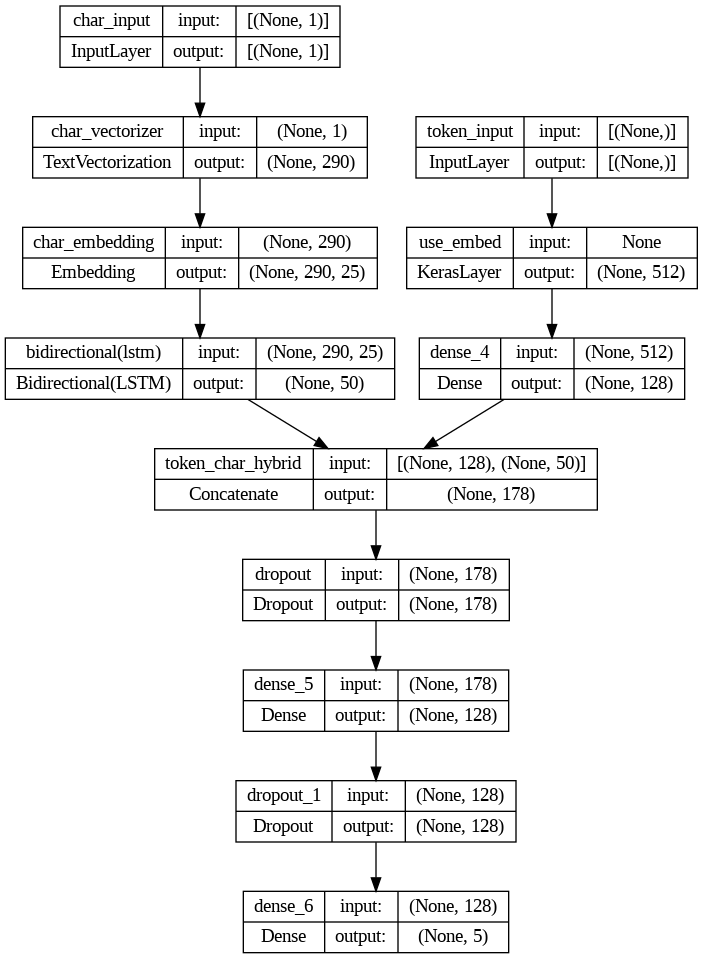

In [83]:
from keras.utils import plot_model
plot_model(model_4, show_shapes=True)

##Modify dataset to combine token and character data

In [84]:
train_hybrid_data = tf.data.Dataset.from_tensor_slices((train_sentences, train_chars))
train_hybrid_labels = tf.data.Dataset.from_tensor_slices((train_labels_one_hot))
train_hybrid_ds = tf.data.Dataset.zip(train_hybrid_data, train_hybrid_labels)
train_hybrid_ds = train_hybrid_ds.batch(32).prefetch(buffer_size=tf.data.AUTOTUNE)

test_hybrid_data = tf.data.Dataset.from_tensor_slices((test_sentences, test_chars))
test_hybrid_labels = tf.data.Dataset.from_tensor_slices((test_labels_one_hot))
test_hybrid_ds = tf.data.Dataset.zip(test_hybrid_data, test_hybrid_labels)
test_hybrid_ds = test_hybrid_ds.batch(32).prefetch(buffer_size=tf.data.AUTOTUNE)

val_hybrid_data = tf.data.Dataset.from_tensor_slices((val_sentences, val_chars))
val_hybrid_labels = tf.data.Dataset.from_tensor_slices((val_labels_one_hot))
val_hybrid_ds = tf.data.Dataset.zip(val_hybrid_data, val_hybrid_labels)
val_hybrid_ds = val_hybrid_ds.batch(32).prefetch(buffer_size=tf.data.AUTOTUNE)

train_hybrid_ds, val_hybrid_ds

(<_PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

In [85]:
#Fit the model
history_4 = model_4.fit(train_hybrid_ds,
                        steps_per_epoch=int(0.1*len(train_hybrid_ds)),
                        epochs=3,
                        validation_data=val_hybrid_ds,
                        validation_steps=int(0.1*len(val_hybrid_ds)),
                        callbacks = [create_tensorboard_callback("experiment_log","model_4")])

Saving TensorBoard log files to: experiment_log/model_4/20240105-065100
Epoch 1/3
562/562 [==============================] - 40s 51ms/step - loss: 0.9809 - accuracy: 0.6077 - val_loss: 0.7833 - val_accuracy: 0.6971
Epoch 2/3
562/562 [==============================] - 26s 47ms/step - loss: 0.7991 - accuracy: 0.6917 - val_loss: 0.7208 - val_accuracy: 0.7274
Epoch 3/3
562/562 [==============================] - 24s 43ms/step - loss: 0.7702 - accuracy: 0.7074 - val_loss: 0.6867 - val_accuracy: 0.7340


In [86]:
#Evaluate the model
model_4.evaluate(val_hybrid_ds)

945/945 [==============================] - 19s 20ms/step - loss: 0.6901 - accuracy: 0.7356


[0.6901012659072876, 0.7356017231941223]

In [87]:
#Make predictions
model_4_pred_probs = model_4.predict(val_hybrid_ds)
model_4_preds = tf.argmax(model_4_pred_probs, axis=1)

945/945 [==============================] - 21s 19ms/step


In [88]:
#Calculate results
model_4_results = calculate_results(val_labels, model_4_preds)
model_4_results

{'accuracy': 73.56017476499404,
 'precision': 0.7345177521956696,
 'recall': 0.7356017476499405,
 'f1': 0.733522167261031}

#Build model with token & character & positional embeddings using Feature Engineering

Note: Any engineered feature needs to be available at test time. In out case, line numbers and total number of lines are available.

##Create positional embeddings

In [89]:
#How many different line numbers we have
train_df["line_number"].value_counts()

0     15000
1     15000
2     15000
3     15000
4     14992
5     14949
6     14758
7     14279
8     13346
9     11981
10    10041
11     7892
12     5853
13     4152
14     2835
15     1861
16     1188
17      751
18      462
19      286
20      162
21      101
22       66
23       33
24       22
25       14
26        7
27        4
28        3
29        1
30        1
Name: line_number, dtype: int64

<Axes: ylabel='Frequency'>

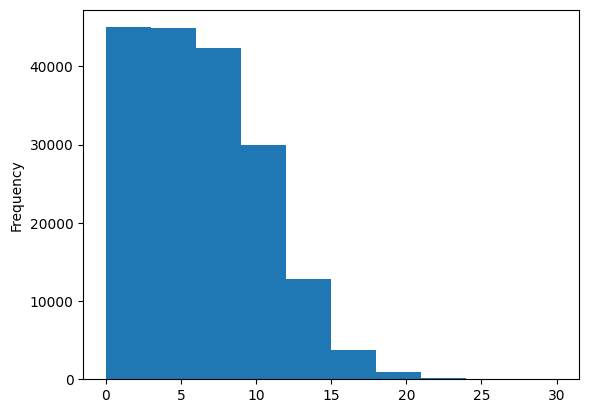

In [90]:
#Check the distribution
train_df.line_number.plot.hist()

In [91]:
#One hot encode line numbers
train_line_numbers_one_hot = tf.one_hot(train_df["line_number"].to_numpy(), depth=15)
test_line_numbers_one_hot = tf.one_hot(test_df["line_number"].to_numpy(), depth=15)
val_line_numbers_one_hot = tf.one_hot(val_df["line_number"].to_numpy(), depth=15)
train_line_numbers_one_hot[:11]

<tf.Tensor: shape=(11, 15), dtype=float32, numpy=
array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.]],
      dtype=float32)>

In [92]:
#How many different total lines values
train_df["total_lines"].value_counts()

11    24468
10    23639
12    22113
9     19400
13    18438
14    14610
8     12285
15    10768
7      7464
16     7429
17     5202
6      3353
18     3344
19     2480
20     1281
5      1146
21      770
22      759
23      264
4       215
24      200
25      182
26       81
28       58
3        32
30       31
27       28
Name: total_lines, dtype: int64

<Axes: ylabel='Frequency'>

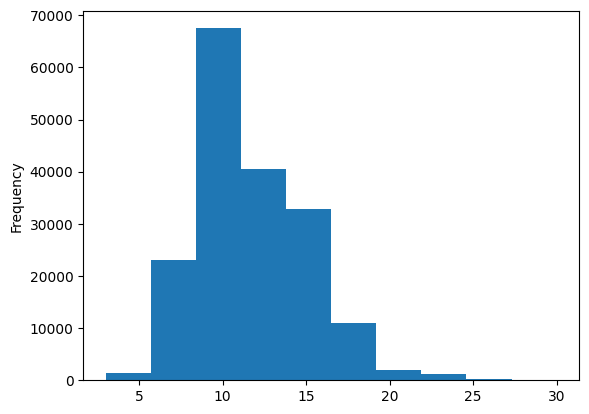

In [93]:
#Check distribution
train_df["total_lines"].plot.hist()

In [94]:
#One hot encode total line numbers
train_total_lines_one_hot = tf.one_hot(train_df["total_lines"].to_numpy(), depth=20)
test_total_lines_one_hot = tf.one_hot(test_df["total_lines"].to_numpy(), depth=20)
val_total_lines_one_hot = tf.one_hot(val_df["total_lines"].to_numpy(), depth=20)
train_total_lines_one_hot[:11]

<tf.Tensor: shape=(11, 20), dtype=float32, numpy=
array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
     

##Create input dataset

In [95]:
train_tribrid_data = tf.data.Dataset.from_tensor_slices((train_line_numbers_one_hot, train_total_lines_one_hot, train_sentences, train_chars))
train_tribrid_labels = tf.data.Dataset.from_tensor_slices((train_labels_one_hot))
train_tribrid_ds = tf.data.Dataset.zip(train_tribrid_data, train_tribrid_labels)
train_tribrid_ds = train_tribrid_ds.batch(32).prefetch(buffer_size=tf.data.AUTOTUNE)

test_tribrid_data = tf.data.Dataset.from_tensor_slices((test_line_numbers_one_hot, test_total_lines_one_hot, test_sentences, test_chars))
test_tribrid_labels = tf.data.Dataset.from_tensor_slices((test_labels_one_hot))
test_tribrid_ds = tf.data.Dataset.zip(test_tribrid_data, test_tribrid_labels)
test_tribrid_ds = test_tribrid_ds.batch(32).prefetch(buffer_size=tf.data.AUTOTUNE)

val_tribrid_data = tf.data.Dataset.from_tensor_slices((val_line_numbers_one_hot, val_total_lines_one_hot, val_sentences, val_chars))
val_tribrid_labels = tf.data.Dataset.from_tensor_slices((val_labels_one_hot))
val_tribrid_ds = tf.data.Dataset.zip(val_tribrid_data, val_tribrid_labels)
val_tribrid_ds = val_tribrid_ds.batch(32).prefetch(buffer_size=tf.data.AUTOTUNE)

train_tribrid_ds, val_tribrid_ds

(<_PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

##Build the model

1. Create the token-level model
2. Create the character-level model
3. Create the model for `line_number` feature
4. Create the model for `total_lines` feature
5. Combine outputs of 1 & 2
6. Combine outputs of 3 & 4 & 5
7. Create an output layer to accept the tribrid embedding
8. Combine the inputs of 1, 2, 3, 4 and outputs into a model

In [96]:
#1.Token model
token_inputs =layers.Input(shape=[], dtype=tf.string)
token_embeddings = embed_layer_encoder(token_inputs)
token_outputs = layers.Dense(128, activation="relu")(token_embeddings)
token_model = tf.keras.Model(token_inputs, token_outputs, name="token_model")

#2.Character model
char_inputs = layers.Input(shape=(1,), dtype=tf.string)
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embedding(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(25))(char_embeddings)
char_model = tf.keras.Model(inputs = char_inputs, outputs = char_bi_lstm)

#3.Create line_number feature model
line_number_inputs = layers.Input(shape=(15,), dtype="float32", name="line_number_input")
line_number_embedding = layers.Dense(32, activation="relu")(line_number_inputs)
line_number_model = tf.keras.Model(line_number_inputs, line_number_embedding)

#4.Create total_lines feature model
total_lines_inputs = layers.Input(shape=(20,), dtype="float32", name="total_lines_input")
total_lines_embedding = layers.Dense(32, activation="relu")(total_lines_inputs)
total_lines_model = tf.keras.Model(total_lines_inputs, total_lines_embedding)

#5.Combine outputs of 1 & 2
concat_token_chars = tf.keras.layers.Concatenate(name="token_char_hybrid")([token_model.output, char_model.output])
#Create output layer - adding dropout (from paper)
combined_token_chars_dense = layers.Dense(256, activation="relu")(concat_token_chars)
final_token_chars_dropout = layers.Dropout(0.5)(combined_token_chars_dense)

#6.Combine outputs of 3 & 4 & 5
concat_tribrid = tf.keras.layers.Concatenate(name="tiribrid_token_chars_position")([line_number_model.output,
                                                                                    total_lines_model.output,
                                                                                    final_token_chars_dropout])

#7.Create output layer
output_layer = layers.Dense(5, activation="softmax")(concat_tribrid)

#8.Construct the model
model_5 = tf.keras.Model(inputs = [line_number_model.input, total_lines_model.input, token_model.input, char_model.input],
                         outputs = output_layer,
                         name = "model_5")

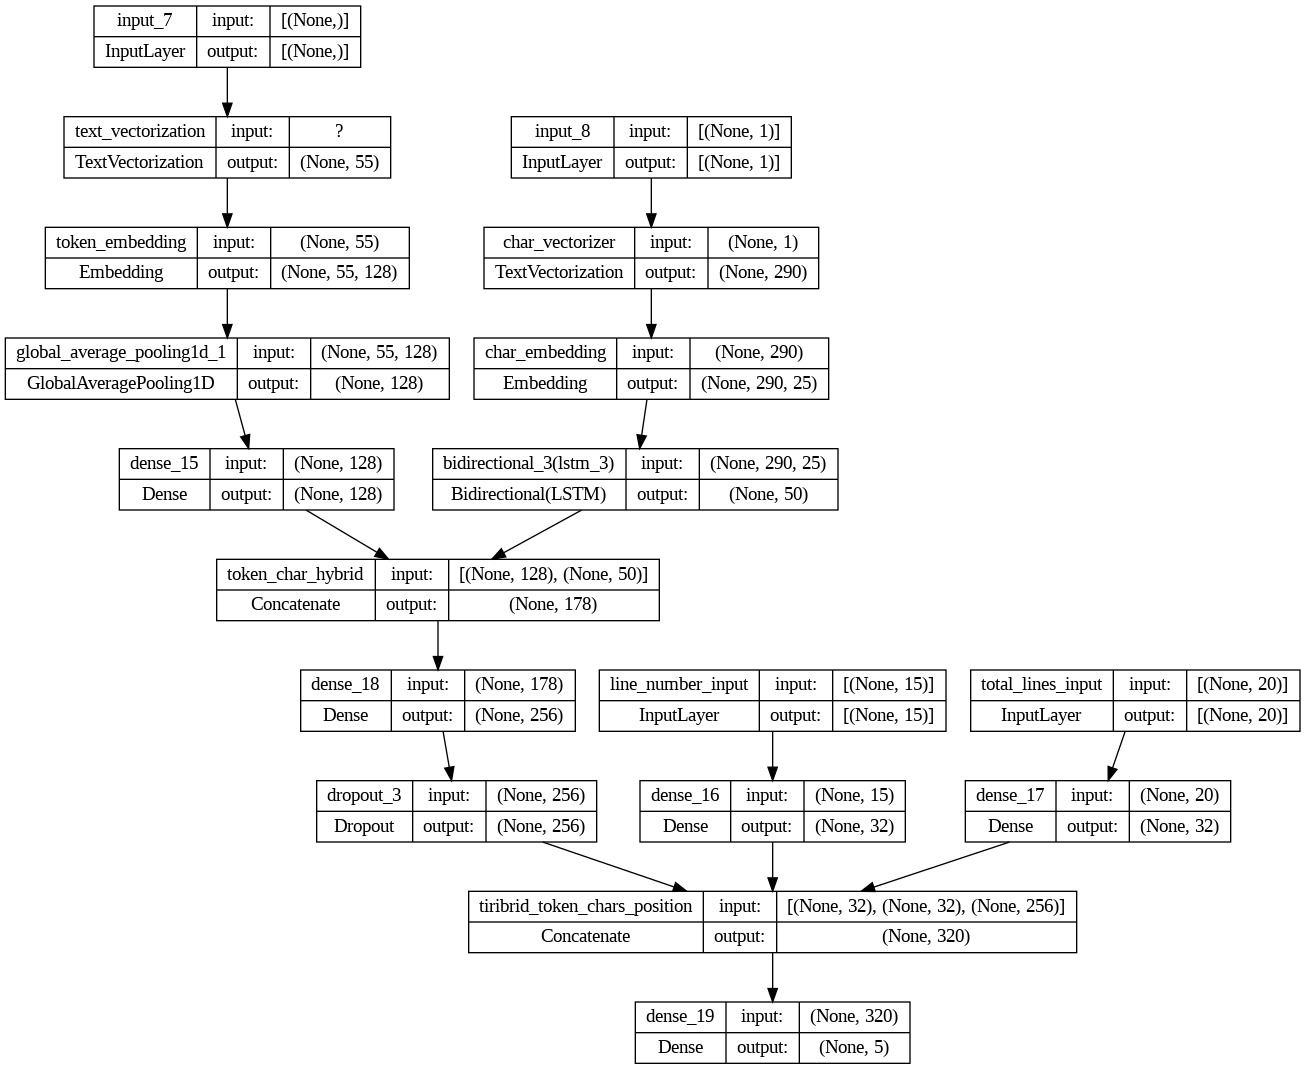

In [132]:
plot_model(model_5, show_shapes=True)

In [98]:
#Compile the model
model_5.compile(
    loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2), #helps to prevent overfitting
    optimizer=tf.keras.optimizers.Adam(),
    metrics=["accuracy"]
)

Note: If our model gets too confident on a single class, it may get stuck on that class and not consider other classes. What label smoothing does is it assigns some of the value from the highest pred prob to other classes, in turn, hopefully imporoving generalization.

Read: https://pyimagesearch.com/2019/12/30/label-smoothing-with-keras-tensorflow-and-deep-learning/

In [99]:
#Fit the model
history_5 = model_5.fit(train_tribrid_ds,
                        steps_per_epoch=int(0.1*len(train_tribrid_ds)),
                        epochs=3,
                        validation_data=val_tribrid_ds,
                        validation_steps=int(0.1*len(val_tribrid_ds)),
                        callbacks = [create_tensorboard_callback("experiment_log","model_5")])

Saving TensorBoard log files to: experiment_log/model_5/20240105-065314
Epoch 1/3
562/562 [==============================] - 39s 51ms/step - loss: 1.0934 - accuracy: 0.7259 - val_loss: 0.9774 - val_accuracy: 0.8049
Epoch 2/3
562/562 [==============================] - 26s 46ms/step - loss: 0.9660 - accuracy: 0.8150 - val_loss: 0.9456 - val_accuracy: 0.8324
Epoch 3/3
562/562 [==============================] - 24s 42ms/step - loss: 0.9475 - accuracy: 0.8271 - val_loss: 0.9361 - val_accuracy: 0.8368


In [100]:
#Evaluate the model
model_5.evaluate(val_tribrid_ds)

945/945 [==============================] - 20s 21ms/step - loss: 0.9351 - accuracy: 0.8341


[0.9350880980491638, 0.8341387510299683]

In [101]:
#Make predictions
model_5_pred_probs = model_5.predict(val_tribrid_ds)
model_5_preds = tf.argmax(model_5_pred_probs, axis = 1)

945/945 [==============================] - 21s 19ms/step


In [102]:
#Calculate results
model_5_results = calculate_results(val_labels, model_5_preds)
model_5_results

{'accuracy': 83.41387528134516,
 'precision': 0.8333112986833696,
 'recall': 0.8341387528134516,
 'f1': 0.8330185530003525}

#Compare all models

In [103]:
#Combine the results of all models
all_models_results = pd.DataFrame({"model_0": baseline_results,
                                   "model_1": model_1_result,
                                   "model_2": model_2_results,
                                   "model_3": model_3_results,
                                   "model_4": model_4_results,
                                   "model_5": model_5_results})

In [104]:
all_models_results = all_models_results.transpose()
all_models_results

,accuracy,precision,recall,f1
model_0,72.183238,0.718647,0.721832,0.698925
model_1,78.422481,0.781209,0.784225,0.781945
model_2,70.743413,0.706650,0.707434,0.703791
model_3,65.904276,0.650201,0.659043,0.649057
model_4,73.560175,0.734518,0.735602,0.733522
model_5,83.413875,0.833311,0.834139,0.833019


In [105]:
#Normalize accuracy
all_models_results["accuracy"] = all_models_results["accuracy"]/100
all_models_results

,accuracy,precision,recall,f1
model_0,0.721832,0.718647,0.721832,0.698925
model_1,0.784225,0.781209,0.784225,0.781945
model_2,0.707434,0.706650,0.707434,0.703791
model_3,0.659043,0.650201,0.659043,0.649057
model_4,0.735602,0.734518,0.735602,0.733522
model_5,0.834139,0.833311,0.834139,0.833019


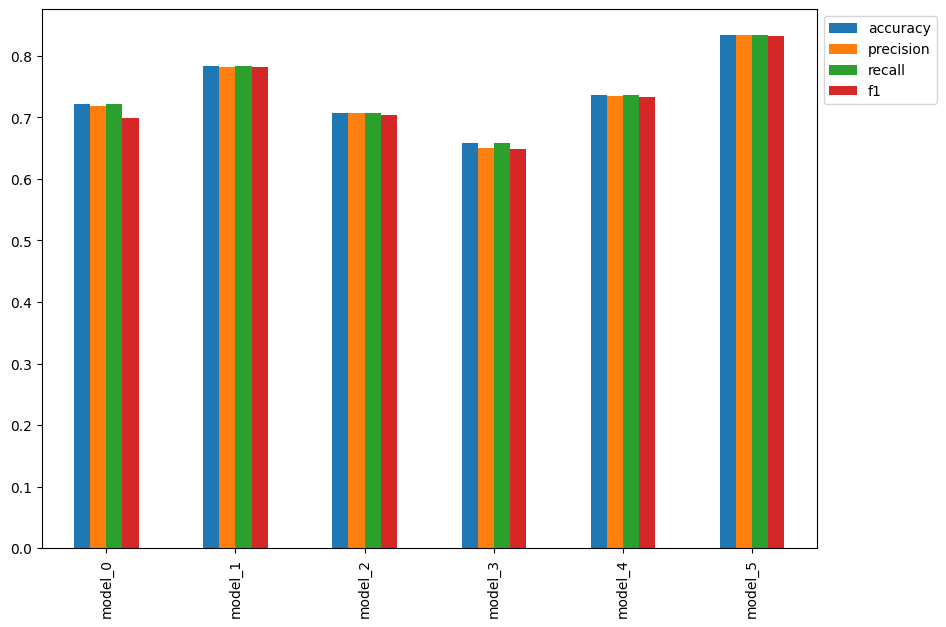

In [106]:
#Visualize
all_models_results.plot(kind="bar", figsize=(10,7)).legend(bbox_to_anchor=(1.0,1.0))

<Axes: >

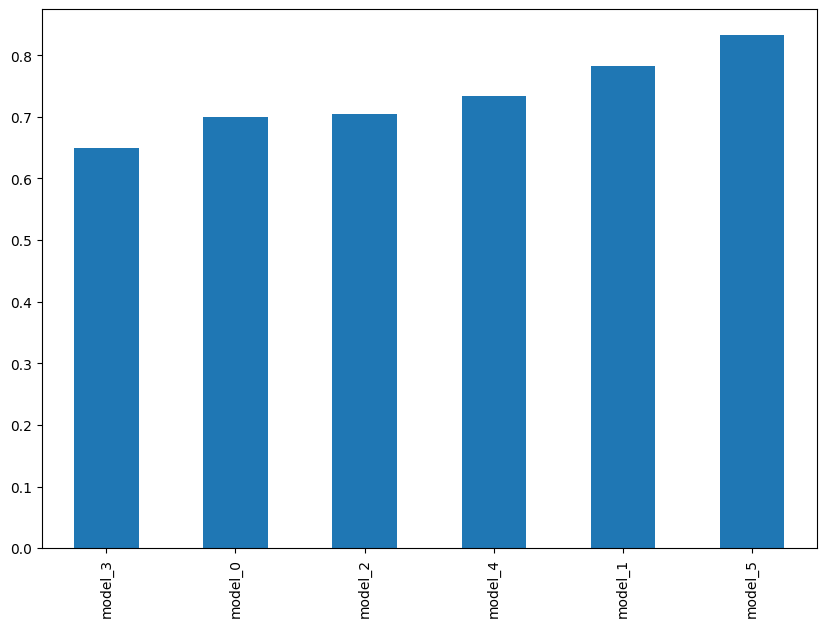

In [107]:
#Visualize f1-score
all_models_results.sort_values("f1", ascending=True)["f1"].plot(kind="bar", figsize=(10,7))

#Save the model

In [108]:
model_5.save("Best_SkimLit_model")

In [109]:
loaded_model=tf.keras.models.load_model("Best_SkimLit_model")

In [110]:
loaded_model.evaluate(val_tribrid_ds)

945/945 [==============================] - 21s 20ms/step - loss: 0.9351 - accuracy: 0.8341


[0.9350880980491638, 0.8341387510299683]

###Make predictions on test dataset

In [111]:
#1.Make predictions on test dataset
loaded_model_pred_probs = loaded_model.predict(test_tribrid_ds)

942/942 [==============================] - 22s 20ms/step


In [118]:
#Get the max prediction probability
max = tf.reduce_max(loaded_model_pred_probs, axis=1)
max[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([0.46161544, 0.36256656, 0.7807629 , 0.680218  , 0.7458491 ,
       0.89710766, 0.5649715 , 0.50047934, 0.448759  , 0.581406  ],
      dtype=float32)>

In [112]:
loaded_model_preds = tf.argmax(loaded_model_pred_probs, axis=1)

###Find the most wrong predictions

In [122]:
#Put predictions into dataframe
predictions_df = pd.DataFrame({"test_text": test_sentences,
                               "test_labels": test_labels,
                               "test_preds": loaded_model_preds,
                               "pred_conf": max})
predictions_df.head()

,test_text,test_labels,test_preds,pred_conf
0,this study analyzed liver function abnormaliti...,0,3,0.461615
1,a post hoc analysis was conducted with the use...,4,0,0.362567
2,liver function tests ( lfts ) were measured at...,4,2,0.780763
3,survival analyses were used to assess the asso...,4,2,0.680218
4,the percentage of patients with abnormal lfts ...,4,4,0.745849


In [123]:
#Sort by the highest prediction confidence
most_wrong_df = predictions_df[predictions_df["test_labels"]!=predictions_df["test_preds"]].sort_values("pred_conf", ascending=False)
most_wrong_df.head()

,test_text,test_labels,test_preds,pred_conf
13874,symptom outcomes will be assessed and estimate...,1,2,0.942955
2388,the primary endpoint is the cumulative three-y...,4,2,0.932137
28602,www.chictr.org registration chictr-trc-@ .,1,0,0.924940
16347,to evaluate the effects of the lactic acid bac...,0,3,0.923952
1827,nct@ ( clinicaltrials.gov ) .,1,0,0.921086


In [124]:
most_wrong_df.tail()

,test_text,test_labels,test_preds,pred_conf
9769,the crystalens ao and restor +@ demonstrated b...,4,2,0.239314
19439,it also looks at whether ` feedback-informed t...,0,1,0.238620
16216,the formative research suggested that rdts wer...,4,2,0.236429
15864,the study showed that the treatment led to imp...,0,3,0.233723
11729,this @ arm randomized prospective double-blind...,2,1,0.228060


In [129]:
#Make function to print most wrong predictions
for row in most_wrong_df[:10].itertuples():
  _,text,label,prediction,pred_confidence = row
  print(f"Sample text: {text}")
  print(f"Label: {class_names[label]}")
  print(f"Prediction: {class_names[prediction]}")
  print(f"Prediction confidence: {pred_confidence}")
  print("---")

Sample text: symptom outcomes will be assessed and estimates of cost-effectiveness made .
Label: CONCLUSIONS
Prediction: METHODS
Prediction confidence: 0.9429552555084229
---
Sample text: the primary endpoint is the cumulative three-year hiv incidence .
Label: RESULTS
Prediction: METHODS
Prediction confidence: 0.9321365356445312
---
Sample text: www.chictr.org registration chictr-trc-@ .
Label: CONCLUSIONS
Prediction: BACKGROUND
Prediction confidence: 0.9249399900436401
---
Sample text: to evaluate the effects of the lactic acid bacterium lactobacillus salivarius on caries risk factors .
Label: BACKGROUND
Prediction: OBJECTIVE
Prediction confidence: 0.9239516854286194
---
Sample text: nct@ ( clinicaltrials.gov ) .
Label: CONCLUSIONS
Prediction: BACKGROUND
Prediction confidence: 0.9210859537124634
---
Sample text: clinicaltrials.gov identifier : nct@ .
Label: CONCLUSIONS
Prediction: BACKGROUND
Prediction confidence: 0.9203699827194214
---
Sample text: -lsb- netherlands trial register ( 